In [23]:
import pandas as pd
import geopandas as gpd
import random
import fiona
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from geopy.distance import geodesic
from pathlib import Path
import random, os, sys
import numpy as np
import zipfile
import seaborn as sns
from archetypal import IDF

sys.path.insert(0, 'C:/Users/mmh/Documents/Codes/cross-sectro-transp-energy-model/')
# importlib.reload(sys.modules['src.calculation'])
from src.func_buildings import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data_dir = 'C:/Users/mmh/Documents/Data/'
data_dir2 = 'C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/9.Data/'

In [24]:
od_file = 'default'

# building cap and location

In [25]:
building_loc = gpd.read_file(data_dir+'Buildings/GA/GA_buildings.shp')
building_loc['BuildingClass'] = 'Commercial'
building_loc.loc[building_loc.BuildingTy.isin(['MidriseApartment','HighriseApartment','IECC']),'BuildingClass'] = 'Residential'
building_loc.loc[building_loc.BuildingTy.isin(['SmallOffice','MediumOffice','LargeOffice',
                                              'PrimarySchool','SecondarySchool']),'BuildingClass'] = 'Industrial'

In [26]:
# %store -r building_cap
# building_cap = pd.read_feather(data_dir+'Buildings/GA/building_cap_100BG.feather')
building_cap = pd.read_feather(data_dir+'Buildings/GA/building_cap_rural.feather')
building_cap = pd.merge(building_cap,building_loc[['ID','BuildingClass']],how='left',on='ID')
building_cap['GEOID'] = building_cap['GEOID'].astype('int64')
# building_cap['TRACTFP'] = building_cap['GEOID'].astype(str).str[0:11]
print(len(building_cap))
building_cap = building_cap[(building_cap.capacity<=500)&(building_cap.capacity>=5)]
print(len(building_cap))
print('size: '+str(round(building_cap.memory_usage(index=True).sum()/1e9,4))+'GB')
building_cap.head()

3207
2701
size: 0.0002GB


,ID,GEOID,Area,latitude,longitude,capacity,BuildingClass
2,5007013188323,131210103091,81248.953328,33.63490535003784,-84.70748775605293,211.924259,Residential
3,5007013188409,131210103091,4860.119042,33.627810000000004,-84.722174,12.676805,Residential
4,5007013188411,131210105402,963.712308,33.53337218757921,-84.55780135614702,8.626163,Industrial
7,5007013188468,131210104021,1495.021808,33.528385905325436,-84.70077578500985,13.381900,Industrial
9,5007013188474,131210104021,1102.616960,33.524434,-84.73556700000002,9.869495,Industrial


In [5]:
building_cap.capacity.describe()

count    13424.000000
mean        55.289708
std         71.157470
min          5.001217
25%         17.206442
50%         32.992576
75%         59.037812
max        498.922801
Name: capacity, dtype: float64

<Axes: xlabel='capacity', ylabel='Count'>

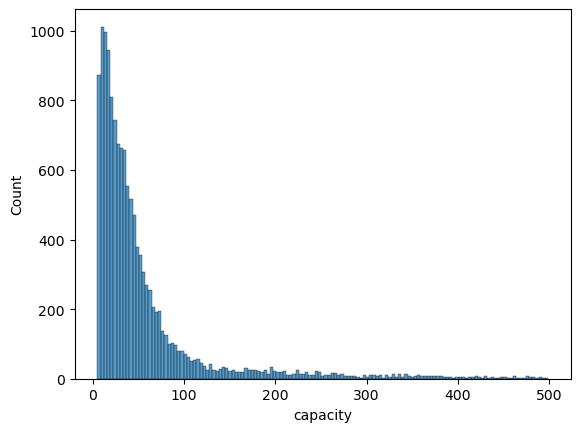

In [6]:
sns.histplot(data=building_cap,x='capacity')

In [35]:
selected_zones = np.unique(building_cap.GEOID.astype('int64'))
print(len(selected_zones))
# selected_zones

17


# OD data processing

need to separate default, winter and summer

In [9]:
cols_mode = ['mode_air','mode_rail','mode_car','mode_bus','mode_walk','mode_bike']
cols_purpose = ['purpose_hbw','purpose_hbo','purpose_wbo','purpose_obo']
cols_time = ['hour_00','hour_01','hour_02','hour_03','hour_04','hour_05','hour_06','hour_07','hour_08','hour_09','hour_10','hour_11','hour_12',
        'hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']
cols = ['origin_zone_id', 'destination_zone_id','total_linked_trips'] + cols_time

In [10]:
# for j in ['winter','summer','default']:
#     if j == 'winter':
#         month_list = ['12','01','02']
#     elif j == 'summer':
#         month_list = ['06','07','08']
#     elif j == 'default':
#         month_list = ['09','05']
#     od_long = pd.DataFrame()
#     for i in month_list:
#         tmp = pd.read_feather(data_dir + 'OD/GDOT_2019_' + i + '_weekday_car_long.feather')
#         tmp['trips'] = tmp['trips'] * tmp['car_share']
#         tmp = tmp[['origin_zone_id', 'destination_zone_id','hour', 'trips']]

#         # Concatenate the DataFrames along the rows
#         od_long = pd.concat([od_long, tmp], axis=0, ignore_index=True, sort=False)

#     # Group by the specified columns and sum the 'trips' column
#     od_long = od_long.groupby(['origin_zone_id', 'destination_zone_id','hour'], as_index=False)['trips'].sum()
    
#     # Normalize 'trips' by the number of months
#     od_long['trips'] /= len(month_list)
    
#     od_long = od_long.rename(columns={'origin_zone_id':'origin','destination_zone_id':'destination'})
#     od_long['origin'] = od_long['origin'].astype('int64')
#     od_long['destination'] = od_long['destination'].astype('int64')
#     print(j+' OD data size: '+str(round(od_long.memory_usage(index=True).sum()/1e9,4))+'GB')
#     if j == 'winter':
#         od_winter = od_long.copy()
#     elif j == 'summer':
#         od_summer = od_long.copy()
#     elif j == 'default':
#         od_default = od_long.copy()   
# del od_long, tmp

# od_winter.to_feather(data_dir + 'OD/od_winter.feather')
# od_summer.to_feather(data_dir + 'OD/od_summer.feather')
# od_default.to_feather(data_dir + 'OD/od_default.feather')

In [11]:
# df = od_long.groupby('hour').agg({'trips':'mean'}).reset_index()
# df.head()
# sns.barplot(data=df,x='hour',y='trips',color='steelblue')
# plt.ylim(0,0.8)

# read trip purpose and OD

In [27]:
purpose_time = pd.read_csv(data_dir+'OD/purpose_by_time.csv')
print(len(purpose_time))
purpose_time.head()

216


,origin_purpose,destination_purpose,hour,share,purpose
0,home,home,0,0.013773,hbh
1,home,work,0,0.000366,hbw
2,home,other,0,0.037755,hbo
3,work,home,0,0.312926,wbh
4,work,work,0,0.004091,wbw


In [13]:
def max_negative(df):
    negative = df[df['occupancy']<0].occupancy.values
    if len(negative)!=0:
        value = np.max(np.abs(negative))
    else:
        value = 0
    return(value)

In [14]:
purpose_time.head()

,origin_purpose,destination_purpose,hour,share,purpose
0,home,home,0,0.013773,hbh
1,home,work,0,0.000366,hbw
2,home,other,0,0.037755,hbo
3,work,home,0,0.312926,wbh
4,work,work,0,0.004091,wbw


# Calibration

In [28]:
veh_occ = 1.67
od_long = pd.read_feather(data_dir+'OD/'+'od_default'+'.feather')
od_long['trips'] = od_long['trips'] * veh_occ
bg_occ = estimate_bg_occ(od_long,selected_zones,purpose_time)

Finish calculation: work
Finish calculation: other
Finish calculation: home
2424
2424


In [29]:
bg_occupancy_selected = bg_occ[bg_occ.stay_type =='home']
building_selected = building_cap[building_cap.BuildingClass=='Residential']
building_selected = building_selected.groupby('GEOID').agg({'capacity':'sum'}).reset_index()
building_schedule = pd.DataFrame()
building_schedule['GEOID'] = np.repeat(selected_zones,24)
building_schedule['hour'] = list(range(0,24))*len(selected_zones)
building_schedule = pd.merge(building_schedule,building_selected[['GEOID','capacity']],how='left',on='GEOID')
building_schedule = pd.merge(building_schedule,
                             bg_occupancy_selected[['GEOID','hour','occupancy']],
                             how='left',on=['GEOID','hour'])
clibration_od_building = building_schedule.capacity.sum()/building_schedule.occupancy.sum()
clibration_od_building

0.0

In [30]:
bg_occupancy_selected = bg_occ[bg_occ.stay_type =='work']
building_selected = building_cap[building_cap.BuildingClass!='Residential']
building_selected = building_selected.groupby('GEOID').agg({'capacity':'sum'}).reset_index()
building_schedule = pd.DataFrame()
building_schedule['GEOID'] = np.repeat(selected_zones,24)
building_schedule['hour'] = list(range(0,24))*len(selected_zones)
building_schedule = pd.merge(building_schedule,building_selected[['GEOID','capacity']],how='left',on='GEOID')
building_schedule = pd.merge(building_schedule,
                             bg_occupancy_selected[['GEOID','hour','occupancy']],
                             how='left',on=['GEOID','hour'])
clibration_od_building_work = building_schedule.capacity.sum()/building_schedule.occupancy.sum()*0.8
clibration_od_building_work

0.0

In [31]:
bg_occupancy_selected = bg_occ[bg_occ.stay_type =='other']
building_selected = building_cap[building_cap.BuildingClass=='Commercial']
building_selected = building_selected.groupby('GEOID').agg({'capacity':'sum'}).reset_index()
building_schedule = pd.DataFrame()
building_schedule['GEOID'] = np.repeat(selected_zones,24)
building_schedule['hour'] = list(range(0,24))*len(selected_zones)
building_schedule = pd.merge(building_schedule,building_selected[['GEOID','capacity']],how='left',on='GEOID')
building_schedule = pd.merge(building_schedule,
                             bg_occupancy_selected[['GEOID','hour','occupancy']],
                             how='left',on=['GEOID','hour'])
clibration_od_building_other = building_schedule.capacity.sum()/building_schedule.occupancy.sum()
clibration_od_building_other

0.0

# Block Group: Occupancy

In [36]:
od_long = pd.read_feather(data_dir+'OD/od_'+od_file+'.feather')
od_long['trips'] = od_long['trips'] * veh_occ
bg_occ = estimate_bg_occ(od_long,selected_zones,purpose_time)

Finish calculation: work
Finish calculation: other
Finish calculation: home
408
408


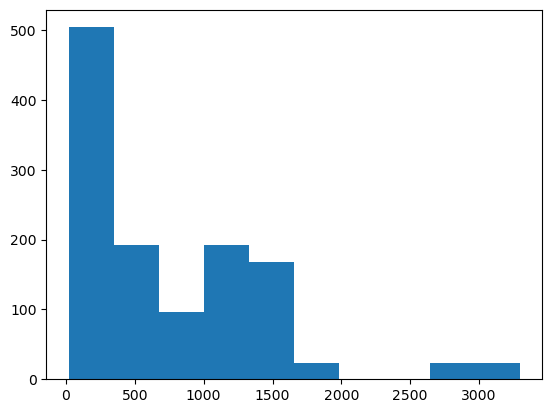

In [37]:
plt.hist(bg_occ.offset)
plt.show()

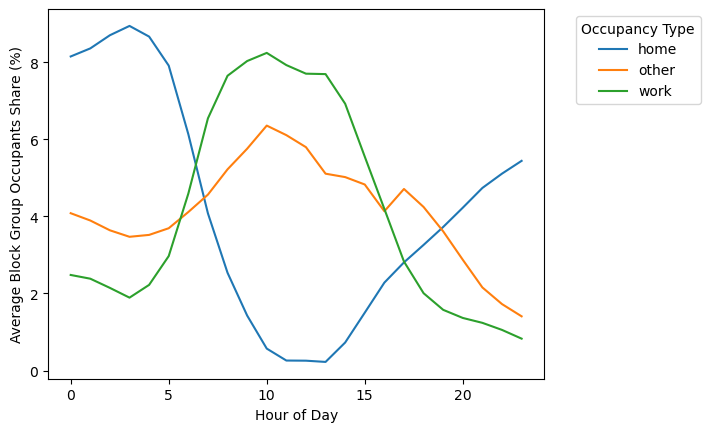

In [38]:
bg_tot = bg_occ.groupby(['origin','stay_type']).agg({'occupancy':'sum'}).reset_index().rename(columns={'occupancy':'total'})
bg_plt = pd.merge(bg_occ,bg_tot,how='left',on=['origin','stay_type'])
bg_plt['share'] = bg_plt['occupancy']/bg_plt['total']*100
bg_plt = bg_plt.groupby(['hour','stay_type']).agg({'share':'mean'}).reset_index()
sns.lineplot(data=bg_plt,x='hour',y='share',hue='stay_type', markers=['o', 's', '^'])
plt.ylabel("Average Block Group Occupants Share (%)")
plt.xlabel("Hour of Day")
# plt.xlim(0,24)
plt.legend(title='Occupancy Type',bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.ylim(0,1800)
plt.show()

# Building: Conduct assignment for each trip purpose
- home -> residential buildings
- work -> non-residential buildings (i.e., industrial & commercial)
- other -> commercial buildings

https://www.nature.com/articles/s41467-019-11685-w

In [217]:
mu = 0.5

In [218]:
# building_na = np.random.normal(10, 5)
fill_random = lambda x: abs(np.random.normal(10, 50)) if pd.isna(x) or x == 0 else x 

### home stay: assign only to residential buildings based on capacity

In [219]:
# residential
building_selected = building_cap[building_cap.BuildingClass=='Residential']
print(len(np.unique(building_selected.ID)))
cutoff = np.percentile(building_selected['capacity'], 90)
print(cutoff)
building_selected.loc[building_selected.capacity>=cutoff,'capacity'] = int(np.random.normal(building_selected.capacity.mean(), 5))
building_selected.capacity.describe()

1277
61.7565962042436


count    1277.000000
mean       26.092070
std        14.588274
min         5.022565
25%        13.443384
50%        26.819943
75%        36.011651
max        61.713836
Name: capacity, dtype: float64

In [220]:
### Clustering
building_selected = building_selected.groupby(['GEOID']).apply(hierarchical_clustering_ward)
print(len(np.unique(building_selected.Cluster)))

Only one building of this type
271


In [221]:
print(len(building_selected))
building_selected.head()

1277


,ID,GEOID,Area,latitude,longitude,capacity,BuildingClass,Cluster
2,5007013188323,131210103091,81248.953328,33.63490535003784,-84.70748775605293,28.000000,Residential,8
3,5007013188409,131210103091,4860.119042,33.627810000000004,-84.722174,12.676805,Residential,3
11,5007013188522,131210104023,3236.861987,33.57099101846627,-84.77277532478413,8.442811,Residential,133
14,5007013188596,131210105343,3033.968820,33.526765,-84.58432649999999,7.913599,Residential,10
15,5007013188597,131210104022,2955.131323,33.55958083761586,-84.69737017329578,7.707964,Residential,128


In [222]:
# gdf = gpd.GeoDataFrame(building_selected, 
#                        geometry=gpd.points_from_xy(building_selected['longitude'], building_selected['latitude']))
# # Plot the GeoDataFrame
# fig, ax = plt.subplots(1, 1)
# gdf.plot(column='Cluster', cmap="Spectral", linewidth=0.8, ax=ax, legend=True)

In [223]:
# building_selected = building_cap[building_cap.BuildingClass=='Residential']
# building_bg = building_selected.groupby(['GEOID']).agg({'capacity':'sum'}).reset_index().rename(columns={'capacity':'capacity_bg'})
# assign_model = pd.merge(building_selected,building_bg,how='left',on=['GEOID'])
# assign_model['PBuilding'] = assign_model['capacity']/assign_model['capacity_bg']
# assign_model['PCluster'] = 1
# assign_model = assign_model.sort_values(['GEOID','ID'])
# assign_model.head()

In [224]:
### Assignment probability
building_cluster = building_selected.groupby(['GEOID','Cluster']).agg({'capacity':'sum'}).reset_index().rename(columns={'capacity':'capacity_Cluster'})
building_tract = building_cluster.groupby(['GEOID']).agg({'capacity_Cluster':'sum'}).reset_index().rename(columns={'capacity_Cluster':'capacity_Tract'})
building_cluster = pd.merge(building_cluster,building_tract,how='left',on=['GEOID'])
building_cluster['numerator'] = np.power(building_cluster['capacity_Cluster']/building_cluster['capacity_Tract'],1+mu)
building_tract = building_cluster.groupby(['GEOID']).agg({'numerator':'sum'}).reset_index().rename(columns={'numerator':'denominator'})
building_cluster = pd.merge(building_cluster,building_tract,how='left',on=['GEOID'])
building_cluster['PCluster'] = building_cluster['numerator']/building_cluster['denominator']
assign_model = pd.merge(building_selected,building_cluster,how='left',on=['GEOID','Cluster'])
assign_model['PBuilding'] = assign_model['capacity']/assign_model['capacity_Cluster']
assign_model = assign_model.sort_values(['GEOID','Cluster','ID'])
print(len(assign_model))
assign_model.head(3)

1277


,ID,GEOID,Area,latitude,longitude,capacity,BuildingClass,Cluster,capacity_Cluster,capacity_Tract,numerator,denominator,PCluster,PBuilding
528,5007013254531,131210103091,6961.925425,33.63141291356119,-84.72154774642901,18.159014,Residential,1,41.322022,5233.385612,0.000702,0.08172,0.008586,0.439451
736,5007013256334,131210103091,8880.390196,33.6315885,-84.7210815,23.163008,Residential,1,41.322022,5233.385612,0.000702,0.08172,0.008586,0.560549
1233,5007013301523,131210103091,7225.821967,33.63021983550179,-84.72101975394426,6.075270,Residential,2,6.075270,5233.385612,0.000040,0.08172,0.000484,1.000000


In [225]:
bg_occupancy_selected = bg_occ[bg_occ.stay_type =='home']
building_ID = np.unique(building_selected.ID)
building_schedule = pd.DataFrame()
building_schedule['ID'] = np.repeat(building_ID,24)
building_schedule['hour'] = list(range(0,24))*len(building_ID)
building_schedule = pd.merge(building_schedule,assign_model[['ID','GEOID','BuildingClass','capacity','PBuilding','PCluster']],how='left',on='ID')
building_schedule = pd.merge(building_schedule,
                             bg_occupancy_selected[['GEOID','hour','occupancy','stay_type']],
                             how='left',on=['GEOID','hour'])
building_schedule['occupancy'] = building_schedule['occupancy'].apply(fill_random)
building_schedule['occupancy_building'] = building_schedule['occupancy'] * building_schedule['PBuilding'] * building_schedule['PCluster']
# calibrate OD to building
building_schedule['occupancy_building'] = building_schedule['occupancy_building']*clibration_od_building
# need to examine how many exceeding caps
building_schedule.loc[building_schedule['occupancy_building']>=building_schedule['capacity'],'occupancy_building'] = building_schedule.loc[building_schedule['occupancy_building']>=building_schedule['capacity'],'capacity']
building_schedule['occupancy_building_frac'] = building_schedule['occupancy_building']/building_schedule['capacity']

building_schedule_residential = building_schedule.copy()
building_schedule.head()

,ID,hour,GEOID,BuildingClass,capacity,PBuilding,PCluster,occupancy,stay_type,occupancy_building,occupancy_building_frac
0,5007013188323,0,131210103091,Residential,28.0,1.0,0.004789,1190.077667,home,21.535513,0.769125
1,5007013188323,1,131210103091,Residential,28.0,1.0,0.004789,1209.836604,home,21.893069,0.781895
2,5007013188323,2,131210103091,Residential,28.0,1.0,0.004789,1242.175790,home,22.478275,0.802796
3,5007013188323,3,131210103091,Residential,28.0,1.0,0.004789,1256.487479,home,22.737258,0.812045
4,5007013188323,4,131210103091,Residential,28.0,1.0,0.004789,1226.186884,home,22.188942,0.792462


In [226]:
building_schedule.occupancy.describe()

count    30648.000000
mean       530.604334
std        434.185427
min          0.015677
25%        152.241215
50%        495.893360
75%        758.798402
max       2752.921647
Name: occupancy, dtype: float64

In [227]:
building_schedule.occupancy_building_frac.describe()

count    30648.000000
mean         0.380485
std          0.348990
min          0.000007
25%          0.099499
50%          0.263530
75%          0.568606
max          1.000000
Name: occupancy_building_frac, dtype: float64

<Axes: xlabel='hour', ylabel='occupancy_building_frac'>

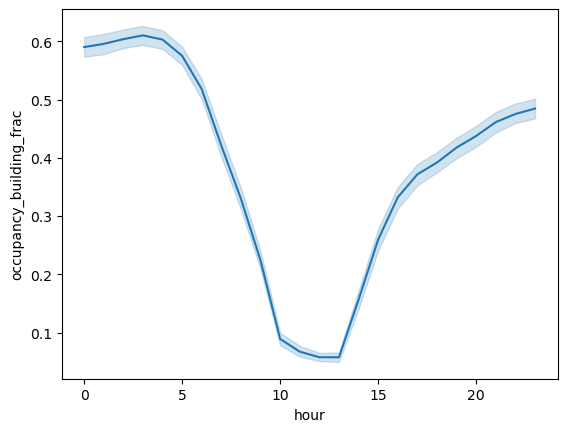

In [228]:
sns.lineplot(data = building_schedule, y='occupancy_building_frac',x='hour')

### work stay: assign only to non-residential buildings based on capacity

In [229]:
# industrial & commercial
building_selected = building_cap[building_cap.BuildingClass!='Residential']
print(len(np.unique(building_selected.ID)))
cutoff = np.percentile(building_selected['capacity'], 90)
print(cutoff)
building_selected.loc[building_selected.capacity>=cutoff,'capacity'] = int(np.random.normal(building_selected.capacity.mean(), 5))
building_selected.capacity.describe()

1424
149.572807505106


count    1424.000000
mean       68.388065
std        34.558359
min         5.187589
25%        40.787800
50%        68.334864
75%        87.695845
max       149.293314
Name: capacity, dtype: float64

In [230]:
### Clustering
building_selected = building_selected.groupby(['GEOID']).apply(hierarchical_clustering_ward)
print(len(np.unique(building_selected.Cluster)))

Only one building of this type
268


In [231]:
### Assignment probability
building_cluster = building_selected.groupby(['GEOID','Cluster']).agg({'capacity':'sum'}).reset_index().rename(columns={'capacity':'capacity_Cluster'})
building_tract = building_cluster.groupby(['GEOID']).agg({'capacity_Cluster':'sum'}).reset_index().rename(columns={'capacity_Cluster':'capacity_Tract'})
building_cluster = pd.merge(building_cluster,building_tract,how='left',on=['GEOID'])
building_cluster['numerator'] = np.power(building_cluster['capacity_Cluster']/building_cluster['capacity_Tract'],mu)
building_tract = building_cluster.groupby(['GEOID']).agg({'numerator':'sum'}).reset_index().rename(columns={'numerator':'denominator'})
building_cluster = pd.merge(building_cluster,building_tract,how='left',on=['GEOID'])
building_cluster['PCluster'] = building_cluster['numerator']/building_cluster['denominator']
building_cluster.head(20)
assign_model = pd.merge(building_selected,building_cluster,how='left',on=['GEOID','Cluster'])
assign_model['PBuilding'] = assign_model['capacity']/assign_model['capacity_Cluster']
assign_model = assign_model.sort_values(['GEOID','Cluster','ID'])
print(len(assign_model))
assign_model.head()

1424


,ID,GEOID,Area,latitude,longitude,capacity,BuildingClass,Cluster,capacity_Cluster,capacity_Tract,numerator,denominator,PCluster,PBuilding
213,5007013251550,131210103091,3774.493443,33.63100734431461,-84.71990780186775,33.785390,Industrial,1,68.088339,16731.797974,0.063792,14.026676,0.004548,0.496199
216,5007013251579,131210103091,3832.315061,33.630713,-84.72021000000001,34.302949,Industrial,1,68.088339,16731.797974,0.063792,14.026676,0.004548,0.503801
578,5007013254115,131210103091,4831.500256,33.63184636974844,-84.720616181576,43.246629,Industrial,2,43.246629,16731.797974,0.050840,14.026676,0.003625,1.000000
985,5007013257045,131210103091,10694.291310,33.62906971438438,-84.72200437985286,95.724315,Industrial,3,95.724315,16731.797974,0.075638,14.026676,0.005392,1.000000
1012,5007013257225,131210103091,6661.273944,33.62994700000001,-84.7219025,49.395267,Commercial,4,49.395267,16731.797974,0.054334,14.026676,0.003874,1.000000


In [232]:
bg_occupancy_selected = bg_occ[bg_occ.stay_type =='work']
building_ID = np.unique(building_selected.ID)
building_schedule = pd.DataFrame()
building_schedule['ID'] = np.repeat(building_ID,24)
building_schedule['hour'] = list(range(0,24))*len(building_ID)
building_schedule = pd.merge(building_schedule,assign_model[['ID','GEOID','BuildingClass','capacity','PCluster','PBuilding']],how='left',on='ID')
building_schedule = pd.merge(building_schedule,bg_occupancy_selected[['GEOID','hour','occupancy','stay_type']],
                             how='left',on=['GEOID','hour'])
building_schedule['occupancy'] = building_schedule['occupancy'].apply(fill_random)
building_schedule['occupancy_building'] = building_schedule['occupancy'] * building_schedule['PCluster'] * building_schedule['PBuilding']
# calibrate OD to building
building_schedule['occupancy_building'] = building_schedule['occupancy_building']*clibration_od_building_work
# need to examine how many caps
building_schedule.loc[building_schedule['occupancy_building']>=building_schedule['capacity'],'occupancy_building'] = building_schedule.loc[building_schedule['occupancy_building']>=building_schedule['capacity'],'capacity']
building_schedule['occupancy_building_frac'] = building_schedule['occupancy_building']/building_schedule['capacity']

building_schedule_commercial = building_schedule[building_schedule.BuildingClass=='Commercial']
print(len(set(building_schedule_commercial.ID)))
building_schedule_industrial = building_schedule[building_schedule.BuildingClass=='Industrial']
print(len(set(building_schedule_industrial.ID)))
building_schedule_industrial.head()

329
1095


,ID,hour,GEOID,BuildingClass,capacity,PCluster,PBuilding,occupancy,stay_type,occupancy_building,occupancy_building_frac
0,5007013188411,0,131210105402,Industrial,8.626163,0.025846,0.141901,59.639532,work,2.242669,0.259985
1,5007013188411,1,131210105402,Industrial,8.626163,0.025846,0.141901,47.163874,work,1.773538,0.205600
2,5007013188411,2,131210105402,Industrial,8.626163,0.025846,0.141901,24.327935,work,0.914821,0.106052
3,5007013188411,3,131210105402,Industrial,8.626163,0.025846,0.141901,70.833544,work,2.663606,0.308782
4,5007013188411,4,131210105402,Industrial,8.626163,0.025846,0.141901,124.659209,work,4.687653,0.543423


<Axes: xlabel='hour', ylabel='occupancy_building_frac'>

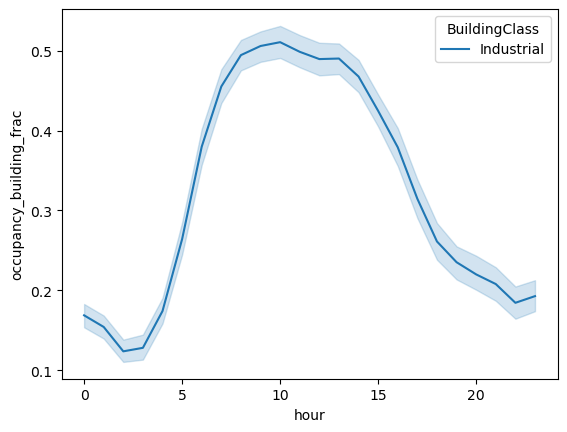

In [233]:
sns.lineplot(data = building_schedule_industrial, y='occupancy_building_frac',x='hour',hue='BuildingClass')

### other stay: assign only to commercial buildings based on capacity

In [234]:
# commercial
building_selected = building_cap[building_cap.BuildingClass=='Commercial']
print(len(np.unique(building_selected.ID)))
cutoff = np.percentile(building_selected['capacity'], 90)
print(cutoff)
building_selected.loc[building_selected.capacity>=cutoff,'capacity'] = int(np.random.normal(building_selected.capacity.mean(), 5))
building_selected.capacity.describe()

329
149.53903164457452


count    329.000000
mean      69.903831
std       33.672350
min        5.187589
25%       43.557507
50%       69.252772
75%       90.000000
max      149.095971
Name: capacity, dtype: float64

In [235]:
### Clustering -> too few commercial buildings can apply this method
building_selected = building_selected.groupby(['GEOID']).apply(hierarchical_clustering_ward)
print(len(np.unique(building_selected.Cluster)))

Only one building of this type
Only one building of this type
61


In [236]:
### Assignment probability
building_cluster = building_selected.groupby(['GEOID','Cluster']).agg({'capacity':'sum'}).reset_index().rename(columns={'capacity':'capacity_Cluster'})
building_tract = building_cluster.groupby(['GEOID']).agg({'capacity_Cluster':'sum'}).reset_index().rename(columns={'capacity_Cluster':'capacity_Tract'})
building_cluster = pd.merge(building_cluster,building_tract,how='left',on=['GEOID'])
building_cluster['numerator'] = np.power(building_cluster['capacity_Cluster']/building_cluster['capacity_Tract'],mu)
building_tract = building_cluster.groupby(['GEOID']).agg({'numerator':'sum'}).reset_index().rename(columns={'numerator':'denominator'})
building_cluster = pd.merge(building_cluster,building_tract,how='left',on=['GEOID'])
building_cluster['PCluster'] = building_cluster['numerator']/building_cluster['denominator']
building_cluster.head(20)
assign_model = pd.merge(building_selected,building_cluster,how='left',on=['GEOID','Cluster'])
assign_model['PBuilding'] = assign_model['capacity']/assign_model['capacity_Cluster']
assign_model = assign_model.sort_values(['GEOID','Cluster','ID'])
print(len(assign_model))
assign_model.head()

329


,ID,GEOID,Area,latitude,longitude,capacity,BuildingClass,Cluster,capacity_Cluster,capacity_Tract,numerator,denominator,PCluster,PBuilding
60,5007013251888,131210103091,8220.857028,33.629665251736114,-84.66272304861111,60.960025,Commercial,1,106.745676,3659.434704,0.170792,6.47445,0.026379,0.571077
102,5007013252987,131210103091,6174.493837,33.63010129129111,-84.6625815349476,45.785652,Commercial,1,106.745676,3659.434704,0.170792,6.47445,0.026379,0.428923
99,5007013252915,131210103091,14634.765403,33.6274565,-84.660871,108.521004,Commercial,2,166.168579,3659.434704,0.213092,6.47445,0.032913,0.653078
199,5007013256444,131210103091,7774.151547,33.6282279905809,-84.66151682410013,57.647575,Commercial,2,166.168579,3659.434704,0.213092,6.47445,0.032913,0.346922
159,5007013255096,131210103091,7909.971772,33.62610600855035,-84.66327382301591,58.654721,Commercial,3,58.654721,3659.434704,0.126603,6.47445,0.019554,1.000000


In [237]:
bg_occupancy_selected = bg_occ[bg_occ.stay_type =='other']
building_ID = np.unique(building_selected.ID)
building_schedule = pd.DataFrame()
building_schedule['ID'] = np.repeat(building_ID,24)
building_schedule['hour'] = list(range(0,24))*len(building_ID)
building_schedule = pd.merge(building_schedule,assign_model[['ID','GEOID','BuildingClass','capacity','PCluster','PBuilding']],
                             how='left',on='ID')
building_schedule = pd.merge(building_schedule,bg_occupancy_selected[['GEOID','hour','occupancy','stay_type']],
                             how='left',on=['GEOID','hour'])
building_schedule['occupancy'] = building_schedule['occupancy'].apply(fill_random)
building_schedule['occupancy_building'] = building_schedule['occupancy'] * building_schedule['PCluster'] * building_schedule['PBuilding']

# calibrate OD to building
building_schedule['occupancy_building'] = building_schedule['occupancy_building']*clibration_od_building_other
set(building_schedule.stay_type)

{'other'}

In [238]:
# Combine two types of buildings together
print(len(building_schedule))
building_schedule = pd.merge(building_schedule,
                             building_schedule_commercial[['ID','hour','occupancy_building']],
                             on=['ID','hour'],how='left')
print(len(building_schedule))
print(len(np.unique(building_schedule.ID)))
# building_schedule['occupancy_building_x'] = building_schedule['occupancy_building_x'].fillna(0)
building_schedule['occupancy_building_y'] = building_schedule['occupancy_building_y'].fillna(0)
building_schedule['occupancy_building'] = (building_schedule['occupancy_building_x']+building_schedule['occupancy_building_y'])

# need to examine how many caps
building_schedule.loc[building_schedule['occupancy_building']>=building_schedule['capacity'],'occupancy_building'] = building_schedule.loc[building_schedule['occupancy_building']>=building_schedule['capacity'],'capacity']
building_schedule['occupancy_building_frac'] = building_schedule['occupancy_building']/building_schedule['capacity']
building_schedule = building_schedule.sort_values(['ID','hour'])
print(set(building_schedule.stay_type))
building_schedule.head()

7896
7896
329
{'other'}


,ID,hour,GEOID,BuildingClass,capacity,PCluster,PBuilding,occupancy,stay_type,occupancy_building_x,occupancy_building_y,occupancy_building,occupancy_building_frac
0,5007013188493,0,131210105203,Commercial,7.374305,0.053388,0.394171,64.208762,other,3.885153,2.442443,6.327596,0.858060
1,5007013188493,1,131210105203,Commercial,7.374305,0.053388,0.394171,40.509624,other,2.451162,1.979443,4.430605,0.600817
2,5007013188493,2,131210105203,Commercial,7.374305,0.053388,0.394171,14.845733,other,0.898288,0.830948,1.729236,0.234495
3,5007013188493,3,131210105203,Commercial,7.374305,0.053388,0.394171,29.500876,other,1.785043,1.119008,2.904051,0.393807
4,5007013188493,4,131210105203,Commercial,7.374305,0.053388,0.394171,65.231291,other,3.947024,7.374305,7.374305,1.000000


In [239]:
building_schedule_commercial = building_schedule[building_schedule_residential.columns]
building_schedule_commercial = building_schedule_commercial.sort_values(['ID','hour'])
building_schedule_commercial.head()

,ID,hour,GEOID,BuildingClass,capacity,PBuilding,PCluster,occupancy,stay_type,occupancy_building,occupancy_building_frac
0,5007013188493,0,131210105203,Commercial,7.374305,0.394171,0.053388,64.208762,other,6.327596,0.858060
1,5007013188493,1,131210105203,Commercial,7.374305,0.394171,0.053388,40.509624,other,4.430605,0.600817
2,5007013188493,2,131210105203,Commercial,7.374305,0.394171,0.053388,14.845733,other,1.729236,0.234495
3,5007013188493,3,131210105203,Commercial,7.374305,0.394171,0.053388,29.500876,other,2.904051,0.393807
4,5007013188493,4,131210105203,Commercial,7.374305,0.394171,0.053388,65.231291,other,7.374305,1.000000


<Axes: xlabel='hour', ylabel='occupancy_building_frac'>

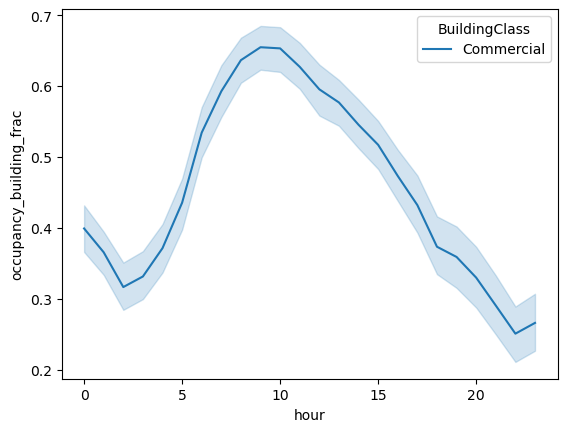

In [240]:
sns.lineplot(data = building_schedule_commercial, y='occupancy_building_frac',x='hour',hue='BuildingClass')

# summary plot

In [241]:
building_schedule_all = pd.concat([building_schedule_residential,building_schedule_commercial,building_schedule_industrial])
building_schedule_all = building_schedule_all.reset_index(drop=True)
building_schedule_all.BuildingClass = building_schedule_all.BuildingClass.astype("category")
building_schedule_all.BuildingClass= building_schedule_all.BuildingClass.cat.set_categories(['Residential','Industrial','Commercial'])
building_schedule_all.head()

,ID,hour,GEOID,BuildingClass,capacity,PBuilding,PCluster,occupancy,stay_type,occupancy_building,occupancy_building_frac
0,5007013188323,0,131210103091,Residential,28.0,1.0,0.004789,1190.077667,home,21.535513,0.769125
1,5007013188323,1,131210103091,Residential,28.0,1.0,0.004789,1209.836604,home,21.893069,0.781895
2,5007013188323,2,131210103091,Residential,28.0,1.0,0.004789,1242.175790,home,22.478275,0.802796
3,5007013188323,3,131210103091,Residential,28.0,1.0,0.004789,1256.487479,home,22.737258,0.812045
4,5007013188323,4,131210103091,Residential,28.0,1.0,0.004789,1226.186884,home,22.188942,0.792462


# Write files

In [242]:
building_schedule_all['stay_type'] = building_schedule_all['stay_type'].astype('bytes')
# building_schedule_all.to_feather(data_dir+'Buildings/Schedule/100BG_'+od_file+'.feather')
building_schedule_all.to_feather(data_dir+'Buildings/Schedule/Rural_'+od_file+'.feather')

In [243]:
building_schedule_all.occupancy_building_frac.describe()

count    64824.000000
mean         0.365809
std          0.357363
min          0.000007
25%          0.073558
50%          0.229843
75%          0.568106
max          1.000000
Name: occupancy_building_frac, dtype: float64

(0.0, 1.1)

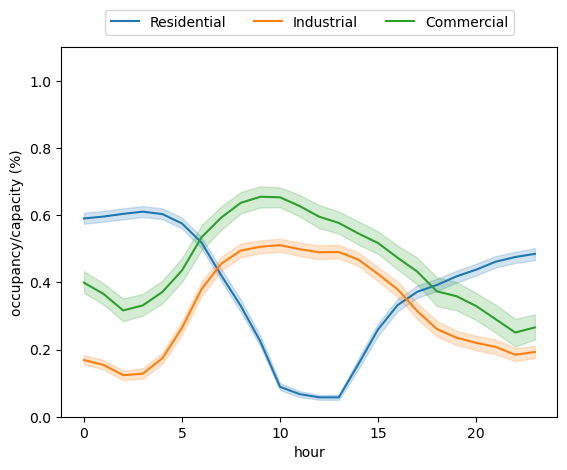

In [244]:
sns.lineplot(data = building_schedule_all,x='hour', y='occupancy_building_frac',hue='BuildingClass')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3)
plt.ylabel('occupancy/capacity (%)')
plt.ylim(0,1.1)

# All season

In [245]:
# all_season = pd.DataFrame()
# for od_file in ['default','summer','winter']:
#     tmp = pd.read_feather(data_dir+'Buildings/Schedule/100BG_'+od_file+'.feather')
#     tmp['season'] = od_file
#     all_season = pd.concat([all_season,tmp])
# sns.lineplot(data = all_season,x='hour', y='occupancy_building_frac',hue='season')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3)
# plt.ylabel('occupancy/capacity (%)')
# plt.ylim(0,1.1)